# LSTM Model for Next Word Prediction

Reference: <br>
https://towardsdatascience.com/exploring-the-next-word-predictor-5e22aeb85d8f

In [1]:
import pickle
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import re
from tensorflow.keras.utils import to_categorical


from sherlock import sherlock
from belling_the_cat import belling_the_cat
from metamorphosis import metamorphosis

## import and preprocess text data

We need to assign a unique integer to each word or symbol because LSTM can only understand real numbers.

Here we first create a feature dictionary `sequences`, which contains all the uniqure words. 

And then convert it to integers using the `tokenizer` package.

In [2]:
cleaned = re.sub(r'\W+', ' ', metamorphosis).lower() # split the .txt into seprate words
tokens = word_tokenize(cleaned)
train_len = 3+1
text_sequences = []
for i in range(train_len,len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)
sequences = {}
count = 1
for i in range(len(tokens)):
    if tokens[i] not in sequences:
        sequences[tokens[i]] = count
        count += 1
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences) 


### Collecting some information of the data

In [3]:
vocabulary_size = len(tokenizer.word_counts)+1

n_sequences = np.empty([len(sequences),train_len], dtype='int32')
for i in range(len(sequences)):
    n_sequences[i] = sequences[i]

### create training set 

Now we create our training data and target data by splitting the sequences into the inputs and output labels. 

Here we use the last 3 words to predict the next word. Thus the list of the first 3 words are inputs, and the list of the following word are labels.

train_inputs: 第i行，第j列，对应到（第i个prev_word list的3个单词当中的第j个，的这个单词对应的index）是1，其余是0

train_targets: 第i行，对应到（next_word list的第i个单词对应的index）是1，其余是0

In [4]:
train_inputs = n_sequences[:,:-1]
train_targets = n_sequences[:,-1]
train_targets = to_categorical(train_targets, num_classes=vocabulary_size)
seq_len = train_inputs.shape[1]
train_inputs.shape

#print(train_targets[0])

(22372, 3)

In [5]:
seq_len

3

## set up the model

Build our model with an embedding layer and two stacked LSTM layers with 50 units, followed by two fully connected (dense) layers.

The first dense layer has 50 units and the second dense layer is our output (softmax) layer and has the number of units equal to the vocabulary size. As for each input, the model will predict the next word from our vocabulary based on the probability. 

In [6]:
model = Sequential()
model.add(Embedding(vocabulary_size, seq_len, input_length=seq_len))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(50,activation='relu'))
model.add(Dense(vocabulary_size, activation='softmax'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 3)              7716      
_________________________________________________________________
lstm (LSTM)                  (None, 3, 50)             10800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 2572)              131172    
Total params: 172,438
Trainable params: 172,438
Non-trainable params: 0
_________________________________________________________________
None


## train the model

In [7]:
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# shuffle?
history = model.fit(train_inputs,train_targets,epochs=20,verbose=1,validation_split=0.2).history

Epoch 1/20
560/560 [==============================] - 6s 6ms/step - loss: 6.3301 - accuracy: 0.0510 - val_loss: 6.3021 - val_accuracy: 0.0489
Epoch 2/20
560/560 [==============================] - 3s 5ms/step - loss: 6.0040 - accuracy: 0.0519 - val_loss: 6.3648 - val_accuracy: 0.0489
Epoch 3/20
560/560 [==============================] - 3s 5ms/step - loss: 5.9745 - accuracy: 0.0519 - val_loss: 6.3945 - val_accuracy: 0.0489
Epoch 4/20
560/560 [==============================] - 3s 5ms/step - loss: 5.9557 - accuracy: 0.0519 - val_loss: 6.4400 - val_accuracy: 0.0489
Epoch 5/20
560/560 [==============================] - 3s 5ms/step - loss: 5.9350 - accuracy: 0.0519 - val_loss: 6.4289 - val_accuracy: 0.0489
Epoch 6/20
560/560 [==============================] - 3s 5ms/step - loss: 5.8637 - accuracy: 0.0519 - val_loss: 6.4369 - val_accuracy: 0.0489
Epoch 7/20
560/560 [==============================] - 3s 5ms/step - loss: 5.7876 - accuracy: 0.0530 - val_loss: 6.4513 - val_accuracy: 0.0514
Epoch 

## save the model 

so that next time don't need to train again

In [8]:
# save
model.save('keras_next_word_model_2.h5')
pickle.dump(history, open("history.p", "wb"))

In [9]:
# next time when using
model = load_model('keras_next_word_model_2.h5')
history = pickle.load(open("history.p", "rb"))

## evaluate the model 

by accruacy and loss

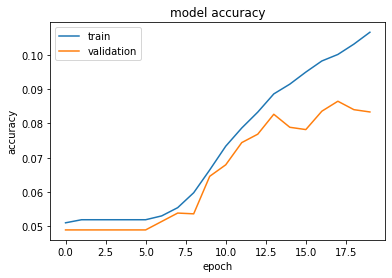

In [10]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

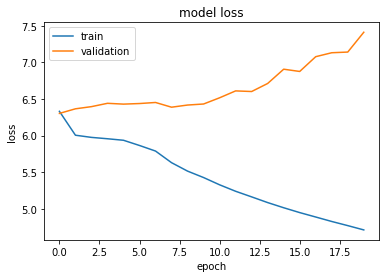

In [11]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

## small trial example

In [ ]:
from keras.preprocessing.sequence import pad_sequences
input_text = input().strip().lower()
encoded_text = tokenizer.texts_to_sequences([input_text])[0]
pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
print(encoded_text, pad_encoded)
for i in (model.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
  pred_word = tokenizer.index_word[i]
  print("Next word suggestion:",pred_word)